**Run the cell below before doing anything else!**

In [ ]:
!pip3 install coolprop

     |████████████████████████████████| 4.2 MB 5.5 MB/s 


# Open Systems and Concentrated Solar Power (Rankine Cycles)

Peter Godart ([ptgodart@mit.edu](mailto:ptgodart@gmail.com))


To successfully mitigate the climate crisis, the consumption of greenhouse gas-emitting fossil fuels must be greatly reduced. Fortuntely, in its place, we have ample solar energy at our disposal to meet the world's power needs. While photovoltaic (PV) solar panels are continually getting cheaper and more efficient, questions remain as to their scalability to meet our global energy consumption. One interesting alternative method for converting solar energy to electricity is to use the Sun's radiation to supply thermal energy to power a thermodynamic cycle that generates mechanical work. This technology, called "Concentrated Solar Power" (CSP), utilizes an array of mirrors to direct sunlight onto a collector atop a central tower, through which a heat transfer fluid flows, as is depicted in this image of a CSP plant in Dubai:

<img src="https://helioscsp.com/wp-content/uploads/2019/04/Dubai-concentrated-solar-power.jpg" height=400px></img>

The heat transfer fluid, which is typically a molten nitrate salt, absorbs this thermal energy and transfers it to a separate closed-loop thermodynamic cycle that uses water as the working fluid. The cycle that is often used in this type of application is a Rankine cycle in which liquid water is pumped to high pressures, then turned to steam using an external heat source, then flowed through a turbine to generate mechanical work, and finally condensed back into liquid by transferring the remaining heat to the environment. The entire system is modeled as follows:

<img src="https://i.imgur.com/IpQctzs.png" width=800px></img>

In this exercise, we will analyze this approach to converting solar energy to electricity and compare it to PV, as well as fossil fuels in several ways. We will focus in on the two subsystems separately to make the analysis easier.

### Rankine Cycle Subsystem

We will start by analyzing the Rankine Cycle subsystem which takes in thermal energy, $\dot{Q}_{in}$, and produces some net mechanical work $\dot{W}_{net}$. The cycle can be depicted graphically as:

<img src="https://i.imgur.com/FGGeYas.png" width=600px></img>

where the states are defined as follows,

 - $1\rightarrow 2$: Liquid water working fluid is pumped from pressure $P_1$ to $P_2$, requiring an input of mechanical power, $\dot{W}_{pump}$.
 - $2\rightarrow 3$: The working fluid is flowed through a heat exchanger, vaporizing it isobarically and bringing its temperature at state 3 to $T_H$.
 - $3\rightarrow 4$: The vapor flows through an isentropic turbine, and as it expands, the turbine spins, generating mechanical power, $\dot{W}_{turbine}.$
 - $4\rightarrow 1$: The working fluid is cooled back the initial temperature at $T_1$, and the cycle repeats.



## Problem 1:

For the purposes of our CSP example, we are interested in computing the efficiency of the cycle, $\eta = \dot{W_{net}}/\dot{Q}_{in}$, to determine what area of solar field is required. What is $\eta$ under the following cycle conditions?

  1. $T_H = 600$ degC
  2. $T_a = 20$ degC
  3. $P_a = 101325$ Pa
  4. $P_2 = P_3 = 60$ bar
  5. $P_4 = P_1 = 0.08$ bar

*Run the following code block to compute $\eta$:*

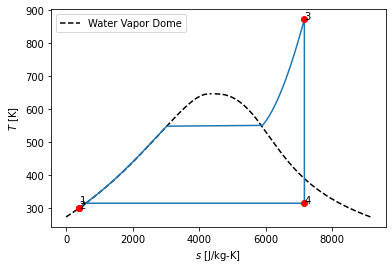

Rankine first law efficiency = 0.398
Carnot efficiency = 0.656
Second law efficiency = 0.607


In [ ]:
import CoolProp as cp
from CoolProp.CoolProp import AbstractState
import numpy as np
from matplotlib import pyplot as plt

Water = cp.AbstractState('HEOS', 'Water')

T_dome = np.linspace(273.06, Water.T_critical()*0.99999, 250)
s_l_dome = []
h_l_dome = []
s_v_dome = []
h_v_dome = []
for T in T_dome:
  Water.update(cp.QT_INPUTS, 0, T)
  s_l_dome.append(Water.smass())
  h_l_dome.append(Water.hmass())
  Water.update(cp.QT_INPUTS, 1, T)
  s_v_dome.append(Water.smass())
  h_v_dome.append(Water.hmass())

# Given:
P_1 = 0.08e5 # Pa
P_2 = 60e5 # Pa
P_4 = P_1 # Isobaric condensation
T_1 = 300 # K
T_2 = T_1 # K (Isothermal pumping)
T_H = 600 + 273.15 # K
T_3 = T_H # K

# Simulate rankine cycle
s_cycle = []
u_cycle = []
T_cycle = []
P_cycle = []
h_cycle = []
# 1->2: Isothermal compression
Water.update(cp.PT_INPUTS, P_1, T_1)
h_1 = Water.hmass()
u_1 = Water.umass()
s_1 = Water.smass()
for P in np.linspace(P_1, P_2, 250):
  Water.update(cp.PT_INPUTS, P, T_1)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
h_2 = h_cycle[-1]
u_2 = u_cycle[-1]
s_2 = s_cycle[-1]
# 2->3: Isobaric evaporation
for T in np.linspace(T_2, T_3, 250):
  Water.update(cp.PT_INPUTS, P_2, T)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
h_3 = h_cycle[-1]
u_3 = u_cycle[-1]
s_3 = s_cycle[-1]
P_3 = P_cycle[-1]
# 3->4: Isentropic expansion through turbine
for P in np.linspace(P_3, P_4, 250):
  Water.update(cp.PSmass_INPUTS, P, s_3)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
h_4 = h_cycle[-1]
u_4 = u_cycle[-1]
s_4 = s_cycle[-1]
T_4 = T_cycle[-1]
# 4->1: Isobaric condensation
for s in np.linspace(s_4, s_1, 250):
  Water.update(cp.PSmass_INPUTS, P_4, s)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
# END SIMULATION

# Plot vapor dome
plt.plot(s_l_dome, T_dome, '--', color='black')
plt.plot(s_v_dome, T_dome, '--', color='black', label='Water Vapor Dome')
# Plot cycle
plt.plot(s_cycle, T_cycle, '-', color='tab:blue')
plt.plot(s_1, T_1, 'o', color='red')
plt.annotate('1', (s_1*1.05, T_1*1.05))
plt.plot(s_2, T_2, 'o', color='red')
plt.annotate('2', (s_2, T_2))
plt.plot(s_3, T_3, 'o', color='red')
plt.annotate('3', (s_3, T_3))
plt.plot(s_4, T_4, 'o', color='red')
plt.annotate('4', (s_4, T_4))
#plt.plot(s_4, T_4, 'o', color='red')
plt.legend()
plt.xlabel('$s$ [J/kg-K]')
plt.ylabel('$T$ [K]')
plt.savefig('name_of_fig.png', dpi=400)
plt.show()

w_dot_net = (h_3 - h_4) + (h_1 - h_2) # W/kg
q_dot_in = (h_3 - h_2) # W/kg
eta_rankine = w_dot_net / q_dot_in
eta_carnot = 1 - T_1 / T_H

print(f'Rankine first law efficiency = {eta_rankine:0.3g}')
print(f'Carnot efficiency = {eta_carnot:0.3g}')
print(f'Second law efficiency = {eta_rankine / eta_carnot:0.3g}') # <- how high can you get this changing P_2, T_H, T_1?

## Problem 2:

Given the value for $\eta$ computed in Problem 1, what is the total heliostat area required for the target power output of 10 MW at peak solar irradiance (i.e. 1000 W/m^2)? Assume 100\% electricity conversion efficiency.

In [ ]:
P_output = 10e6 # W
q_dot_solar = 1000 # W/m^2
Q_dot_solar = P_output / eta_rankine
A_solar_field = Q_dot_solar / q_dot_solar
print(f'At eta_rankine={eta_rankine:.3g}, need {Q_dot_solar*1e-6:.3g} MW of thermal energy.')
print(f'Requires {A_solar_field*1e-6:0.2g} km^2 of heliostats.')

At eta_rankine=0.398, need 25.1 MW of thermal energy.
Requires 0.025 km^2 of heliostats.


## Solar Collection Subsystem

With a sense for how much solar area is required for achieving the desired power output, we can now compute the flow rates necessary for the molten salt heat transfer fluid. We can model this subsystem as follows:

<img src="https://i.imgur.com/xAwJCL6.png" width=600px></img>



## Problem 3:

What is the flow rate of molten nitrate salt required to achieve a target output temperature of 600 degC at peak solar irradiance? Assume the following:

 1. Ambient temperature, $T_a=$ 300 K
 2. $T_L = 300$ degC
 3. $h_{conv} = 25$ W/m^2-K
 4. $h_{rad} = 50$ W/m^2-K

 *Run the following code block:*

In [ ]:
MoltenSalt = AbstractState('INCOMP', 'NaK')
MoltenSalt.update(cp.PT_INPUTS, 101325, 600)
P_a = 101325 # Pa
T_a = 300 + 273.15 # K
T_in = T_a
h_conv = 25 # W/m^2-K
h_rad = 50 # W/m^2-K
A_collector = 30 # m^2
sigma = 5.67e-8 # W/m^2-K^4
MoltenSalt.update(cp.PT_INPUTS, P_a, T_a)
h_in = MoltenSalt.hmass()
# First Law: d/dt(E_cv) = 0 = d/dt(Q_in) - d/dt(Q_out) - d/dt(W_shaft_net) + m_dot*(h_in - h_out)
T_out = 600 + 273.15 # K
MoltenSalt.update(cp.PT_INPUTS, P_a, T_out)
h_out = MoltenSalt.hmass()
m_dot = -(Q_dot_solar - A_collector*(h_conv + h_rad)*(T_out - T_a)) / (h_in - h_out)
print(f'A flow rate of {m_dot:.3g} kg/s is required.')

A flow rate of 53.6 kg/s is required.


## Problem 4:

How much CO$_2$ is offset per year by running CSP compared to methane (CH$_4$) combustion? Assume CH$_4$ combustion has a carbon intensity of 60 g CO$_2$/MJ thermal and that the plant generates power 50\% of the time (0.5 capacity factor). *hint: use the efficiency you compute for the Rankine Cycle above assuming same conditions otherwise.*


In [ ]:
I_CH4 = 60e-3/1e6 # kg/J
capacity_factor = 0.5
seconds_per_year = 31556926 # s
E_total = P_output * capacity_factor * seconds_per_year # J
m_co2_emissions = I_CH4 * E_total # kg

print(f'Total CO2 avoided each year: {m_co2_emissions*1e-6:.3g} kt CO2')

Total CO2 avoided each year: 9.47 kt CO2


## Problem 5:

How does the area required for this solar field compare to that required of a conventional PV solar field? Assuming the solar panels have an efficiency of 20\% and the same peak solar irradiance. Briefly comment on the advantages and drawbacks of CSP over PV.

In [ ]:
eta_pv = 0.2
A_pv = P_output / q_dot_solar / eta_pv
print(f'{A_pv*1e-6:0.2g} km^2 PV panels is required ({A_pv/A_solar_field:0.3g}x greater than CSP)')

0.05 km^2 PV panels is required (1.99x greater than CSP)
